## Image Classification Using CNN: Data Processing, Training, and Evaluation with Grad-CAM Analysis

# Importing Libraries

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
from tqdm import tqdm


# Loading DataSet

In [18]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Argument parser for test data path
if "ipykernel_launcher" in sys.argv[0]:  # Running in Jupyter Notebook
    arguments = argparse.Namespace(test_data_dir=r"C:\Users\Mohamed Sakr\Downloads\data\test")
else:
    parser = argparse.ArgumentParser()
    parser.add_argument("--test_data_dir", type=str, required=True, help="Path to the test data directory")
    arguments = parser.parse_args()

# Dataset paths
main_data_dir = r"C:\Users\Mohamed Sakr\Downloads\data\train"
test_data_path = arguments.test_data_dir
additional_test_data_dir = r"C:\Users\Mohamed Sakr\Downloads\data\test"

# Data transformations (Preprocessing: Resizing, Normalization, Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transform for validation and test sets (without augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
main_dataset = datasets.ImageFolder(root=main_data_dir, transform=train_transforms)
class_labels = main_dataset.classes


# Data Splitting and visualization

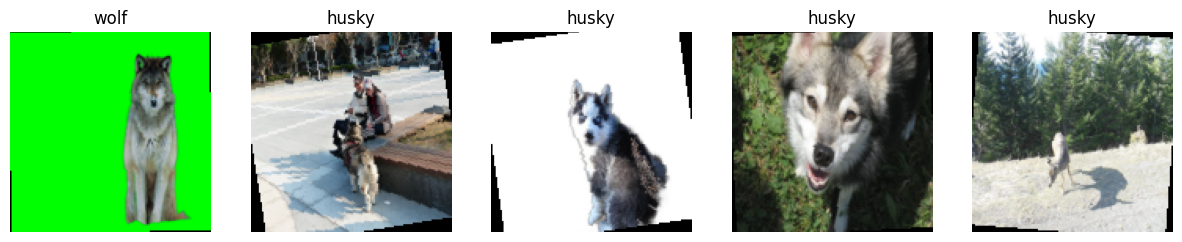

In [19]:
# Data Splitting (Fixing Data Leakage)
np.random.seed(42)
indices_list = np.arange(len(main_dataset))
np.random.shuffle(indices_list)
train_split_size = int(0.8 * len(main_dataset))
train_indices_list, val_indices_list = indices_list[:train_split_size], indices_list[train_split_size:]
train_subset = Subset(main_dataset, train_indices_list)
val_subset = Subset(main_dataset, val_indices_list)

# Data Loaders
train_data_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=2)

# Sample Data Visualization
def display_images(dataset, class_labels):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    mean_values = np.array([0.5, 0.5, 0.5])
    std_values = np.array([0.5, 0.5, 0.5])
    for idx in range(5):
        img, lbl = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * std_values + mean_values  # Reverse normalization
        img = np.clip(img, 0, 1)
        axes[idx].imshow(img)
        axes[idx].set_title(class_labels[lbl])
        axes[idx].axis("off")
    plt.show()

display_images(train_subset, class_labels)


# CNN Model

In [20]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_layer1 = nn.Linear(32 * 32 * 32, 64)
        self.fc_layer2 = nn.Linear(64, num_classes)
        self.activation = nn.ReLU()
        self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool_layer(self.activation(self.conv_layer1(x)))  
        x = self.pool_layer(self.activation(self.conv_layer2(x)))  
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc_layer1(x))
        x = self.fc_layer2(x)
        return self.output_activation(x)


# Training Model

In [21]:
# Train Model
def train_custom_model(model, train_loader, val_loader, epochs=10, lr=0.001, save_path="best_model.pth"):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    best_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, lbls)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation
        model.eval()
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, 1)
                total_preds += lbls.size(0)
                correct_preds += (predicted == lbls).sum().item()

        val_accuracy = 100 * correct_preds / total_preds
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with {val_accuracy:.2f}% accuracy")

    return model

# Hyperparameter Tuning
def tune_hyperparameters(train_dataset, val_dataset):
    learning_rates_list = [0.001, 0.0001]
    batch_sizes_list = [8, 16]
    tuning_results = []

    for lr_val in learning_rates_list:
        for batch_val in batch_sizes_list:
            print(f"Training with lr={lr_val}, batch_size={batch_val}")
            train_loader = DataLoader(train_dataset, batch_size=batch_val, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_val, shuffle=False)
            model = CustomCNN(num_classes=len(class_labels))
            trained_model = train_custom_model(model, train_loader, val_loader, lr=lr_val)

            # Evaluate on validation set
            correct_preds = 0
            total_preds = 0
            model.eval()
            with torch.no_grad():
                for imgs, lbls in val_loader:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    outputs = model(imgs)
                    _, predicted = torch.max(outputs, 1)
                    total_preds += lbls.size(0)
                    correct_preds += (predicted == lbls).sum().item()
            val_accuracy = 100 * correct_preds / total_preds

            # Store results
            tuning_results.append((lr_val, batch_val, val_accuracy, trained_model))

    results_df = pd.DataFrame(tuning_results, columns=["Learning Rate", "Batch Size", "Validation Accuracy", "Model"])
    print("\nHyperparameter Tuning Results:")
    print(results_df.drop(columns=["Model"]))  
    return tuning_results


# Applying Grad-CAM 

In [22]:
# Apply Grad-CAM
def apply_gradcam(model, img):
    model.eval()
    img = img.unsqueeze(0).to(device)  
    img.requires_grad = True

    # Hook to capture the activations and gradients
    activations = []
    gradients = []

    def save_activation(module, input, output):
        activations.append(output)

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])  

    # Register hooks
    hook_a = model.conv_layer2.register_forward_hook(save_activation)
    hook_g = model.conv_layer2.register_full_backward_hook(save_gradient)  

    # Forward pass
    output = model(img)
    class_index = torch.argmax(output).item()

    # Zero gradients
    model.zero_grad()

    # Backward pass
    output[0, class_index].backward()

    # Get the gradients and activations
    gradients = gradients[0]
    activations = activations[0]

    # Remove hooks
    hook_a.remove()
    hook_g.remove()

    # Debugging: Print shapes
    print("Gradients shape:", gradients.shape)
    print("Activations shape:", activations.shape)

    # Compute the weights
    weights = torch.mean(gradients, dim=(0, 2, 3))  

    # Generate heatmap
    heatmap = torch.zeros(activations.shape[2:]).to(device)
    for i in range(weights.shape[0]):
        heatmap += weights[i] * activations[0, i]

    # Apply ReLU to the heatmap
    heatmap = torch.clamp(heatmap, min=0)
    heatmap = heatmap.cpu().detach().numpy()
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    img_np = img.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

    # Display the image and heatmap
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.show()
# Display Grad-CAM for 4 samples
def show_gradcam_samples(model, dataset):
    for i in range(4):
        img, lbl = dataset[i]
        apply_gradcam(model, img)

# Final Evaluation

Training with lr=0.001, batch_size=8


Epoch 1/10: 100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


Epoch 1, Loss: 5.7024, Validation Accuracy: 42.86%
Best model saved with 42.86% accuracy


Epoch 2/10: 100%|██████████| 7/7 [00:00<00:00, 12.02it/s]


Epoch 2, Loss: 4.2035, Validation Accuracy: 50.00%
Best model saved with 50.00% accuracy


Epoch 3/10: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s]


Epoch 3, Loss: 3.8804, Validation Accuracy: 71.43%
Best model saved with 71.43% accuracy


Epoch 4/10: 100%|██████████| 7/7 [00:00<00:00, 11.80it/s]


Epoch 4, Loss: 3.2138, Validation Accuracy: 64.29%


Epoch 5/10: 100%|██████████| 7/7 [00:00<00:00, 12.02it/s]


Epoch 5, Loss: 2.7795, Validation Accuracy: 78.57%
Best model saved with 78.57% accuracy


Epoch 6/10: 100%|██████████| 7/7 [00:00<00:00, 12.12it/s]


Epoch 6, Loss: 2.7071, Validation Accuracy: 64.29%


Epoch 7/10: 100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


Epoch 7, Loss: 2.6862, Validation Accuracy: 85.71%
Best model saved with 85.71% accuracy


Epoch 8/10: 100%|██████████| 7/7 [00:00<00:00, 12.31it/s]


Epoch 8, Loss: 2.5141, Validation Accuracy: 71.43%


Epoch 9/10: 100%|██████████| 7/7 [00:00<00:00, 12.24it/s]


Epoch 9, Loss: 2.5288, Validation Accuracy: 64.29%


Epoch 10/10: 100%|██████████| 7/7 [00:00<00:00, 11.34it/s]


Epoch 10, Loss: 2.4895, Validation Accuracy: 64.29%
Training with lr=0.001, batch_size=16


Epoch 1/10: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch 1, Loss: 2.7972, Validation Accuracy: 42.86%
Best model saved with 42.86% accuracy


Epoch 2/10: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]


Epoch 2, Loss: 3.0977, Validation Accuracy: 42.86%


Epoch 3/10: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Epoch 3, Loss: 3.0386, Validation Accuracy: 50.00%
Best model saved with 50.00% accuracy


Epoch 4/10: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Epoch 4, Loss: 2.5070, Validation Accuracy: 64.29%
Best model saved with 64.29% accuracy


Epoch 5/10: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch 5, Loss: 2.3784, Validation Accuracy: 64.29%


Epoch 6/10: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]


Epoch 6, Loss: 2.0851, Validation Accuracy: 85.71%
Best model saved with 85.71% accuracy


Epoch 7/10: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s]


Epoch 7, Loss: 1.8941, Validation Accuracy: 85.71%


Epoch 8/10: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


Epoch 8, Loss: 1.8990, Validation Accuracy: 78.57%


Epoch 9/10: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch 9, Loss: 1.7256, Validation Accuracy: 85.71%


Epoch 10/10: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]


Epoch 10, Loss: 1.4911, Validation Accuracy: 64.29%
Training with lr=0.0001, batch_size=8


Epoch 1/10: 100%|██████████| 7/7 [00:00<00:00, 10.49it/s]


Epoch 1, Loss: 5.1176, Validation Accuracy: 57.14%
Best model saved with 57.14% accuracy


Epoch 2/10: 100%|██████████| 7/7 [00:00<00:00, 10.69it/s]


Epoch 2, Loss: 4.8659, Validation Accuracy: 42.86%


Epoch 3/10: 100%|██████████| 7/7 [00:00<00:00, 10.89it/s]


Epoch 3, Loss: 4.7754, Validation Accuracy: 50.00%


Epoch 4/10: 100%|██████████| 7/7 [00:00<00:00, 10.08it/s]


Epoch 4, Loss: 4.7033, Validation Accuracy: 21.43%


Epoch 5/10: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s]


Epoch 5, Loss: 4.6032, Validation Accuracy: 42.86%


Epoch 6/10: 100%|██████████| 7/7 [00:00<00:00, 10.35it/s]


Epoch 6, Loss: 4.5728, Validation Accuracy: 50.00%


Epoch 7/10: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s]


Epoch 7, Loss: 4.4727, Validation Accuracy: 50.00%


Epoch 8/10: 100%|██████████| 7/7 [00:00<00:00,  9.60it/s]


Epoch 8, Loss: 4.3574, Validation Accuracy: 50.00%


Epoch 9/10: 100%|██████████| 7/7 [00:00<00:00, 10.75it/s]


Epoch 9, Loss: 4.2705, Validation Accuracy: 50.00%


Epoch 10/10: 100%|██████████| 7/7 [00:00<00:00, 10.60it/s]


Epoch 10, Loss: 4.2278, Validation Accuracy: 50.00%
Training with lr=0.0001, batch_size=16


Epoch 1/10: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch 1, Loss: 2.7270, Validation Accuracy: 42.86%
Best model saved with 42.86% accuracy


Epoch 2/10: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 2, Loss: 2.6279, Validation Accuracy: 50.00%
Best model saved with 50.00% accuracy


Epoch 3/10: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch 3, Loss: 2.5012, Validation Accuracy: 50.00%


Epoch 4/10: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 4, Loss: 2.4669, Validation Accuracy: 50.00%


Epoch 5/10: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch 5, Loss: 2.5662, Validation Accuracy: 50.00%


Epoch 6/10: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]


Epoch 6, Loss: 2.3467, Validation Accuracy: 50.00%


Epoch 7/10: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 7, Loss: 2.3588, Validation Accuracy: 50.00%


Epoch 8/10: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]


Epoch 8, Loss: 2.2907, Validation Accuracy: 78.57%
Best model saved with 78.57% accuracy


Epoch 9/10: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch 9, Loss: 2.2438, Validation Accuracy: 71.43%


Epoch 10/10: 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch 10, Loss: 2.2005, Validation Accuracy: 71.43%

Hyperparameter Tuning Results:
   Learning Rate  Batch Size  Validation Accuracy
0         0.0010           8            78.571429
1         0.0010          16            78.571429
2         0.0001           8            50.000000
3         0.0001          16            71.428571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Accuracy: 89.06%
Gradients shape: torch.Size([1, 32, 64, 64])
Activations shape: torch.Size([1, 32, 64, 64])


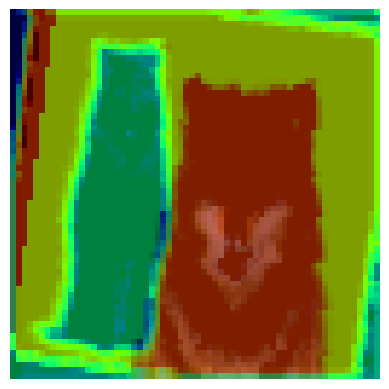

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gradients shape: torch.Size([1, 32, 64, 64])
Activations shape: torch.Size([1, 32, 64, 64])


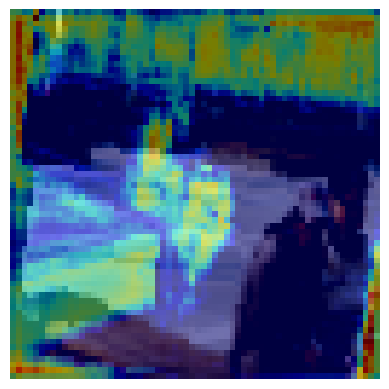

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gradients shape: torch.Size([1, 32, 64, 64])
Activations shape: torch.Size([1, 32, 64, 64])


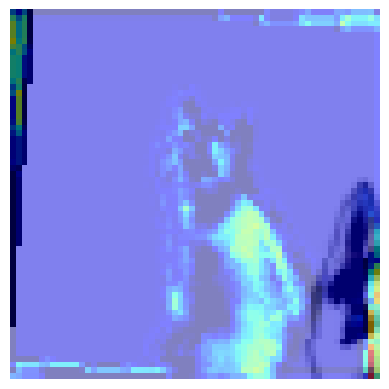

Gradients shape: torch.Size([1, 32, 64, 64])
Activations shape: torch.Size([1, 32, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


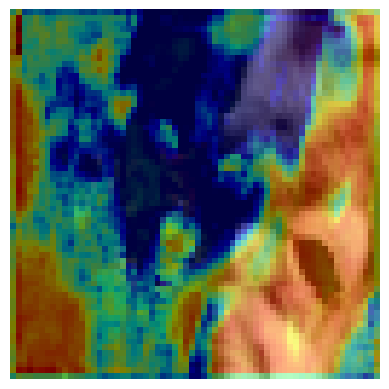

In [23]:
# Final Evaluation
def evaluate_on_test_data(model, test_dir):
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total_preds += lbls.size(0)
            correct_preds += (predicted == lbls).sum().item()
    print(f'Test Accuracy: {100 * correct_preds / total_preds:.2f}%')

# Training the model with hyperparameter tuning
tuning_results = tune_hyperparameters(train_subset, val_subset)
best_trained_model = CustomCNN(num_classes=len(class_labels))
best_trained_model.load_state_dict(torch.load("best_model.pth"))  
best_trained_model.to(device)

# Evaluate on test data
evaluate_on_test_data(best_trained_model, test_data_path)

# Show Grad-CAM samples
show_gradcam_samples(best_trained_model, train_subset)


# Fix Data Leakage and Test on Extra Dataset

In [24]:

additional_test_dataset = datasets.ImageFolder(root=additional_test_data_dir, transform=test_transforms)
additional_test_loader = DataLoader(additional_test_dataset, batch_size=8, shuffle=False)
evaluate_on_test_data(best_trained_model, additional_test_data_dir)

Test Accuracy: 89.06%
